<a href="https://colab.research.google.com/github/ngcheeyuan/Classification_projects/blob/main/toxic_comments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
ds , ds_info = tfds.load('civil_comments' ,
                        shuffle_files = True,
                        with_info = True,
                        as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/civil_comments/CivilComments/1.0.0.incomplete3377XM/civil_comments-train.tfrecord


  0%|          | 0/1804874 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/civil_comments/CivilComments/1.0.0.incomplete3377XM/civil_comments-validation.tfrecord


  0%|          | 0/97320 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/civil_comments/CivilComments/1.0.0.incomplete3377XM/civil_comments-test.tfrecord


  0%|          | 0/97320 [00:00<?, ? examples/s]

Dataset civil_comments downloaded and prepared to /root/tensorflow_datasets/civil_comments/CivilComments/1.0.0. Subsequent calls will reuse this data.


## Baseline model

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
ds_info

tfds.core.DatasetInfo(
    name='civil_comments',
    version=1.0.0,
    description='This version of the CivilComments Dataset provides access to the primary
seven labels that were annotated by crowd workers, the toxicity and other
tags are a value between 0 and 1 indicating the fraction of annotators that
assigned these attributes to the comment text.

The other tags are only available for a fraction of the input examples. They
are currently ignored for the main dataset; the CivilCommentsIdentities set
includes those labels, but only consists of the subset of the data with them.
The other attributes that were part of the original CivilComments release are
included only in the raw data. See the Kaggle documentation for more details
about the available features.

The comments in this dataset come from an archive of the Civil Comments
platform, a commenting plugin for independent news sites. These public comments
were created from 2015 - 2017 and appeared on approximately 50 English-lan

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame(ds['train'])

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df.head(5),len(df)

(                                                   0                                               1
 0  tf.Tensor(b'I think your bad wolf is winning.'...  tf.Tensor(0.16666667, shape=(), dtype=float32)
 1  tf.Tensor(b"And lets not forget, at the very b...         tf.Tensor(0.0, shape=(), dtype=float32)
 2  tf.Tensor(b"how much tax that child pays regar...         tf.Tensor(0.0, shape=(), dtype=float32)
 3  tf.Tensor(b'My sister found her son after more...         tf.Tensor(0.0, shape=(), dtype=float32)
 4  tf.Tensor(b'Jesus taught us to call God Father...         tf.Tensor(0.0, shape=(), dtype=float32),
 1804874)

In [ ]:
df_sample =df.sample(frac = 0.1)

In [ ]:
df_sample.rename(columns = {0:'text' , 1:'label'} , inplace = True)
df_sample.reset_index(drop = True, inplace = True)

In [ ]:
df_sample['label'] = df_sample['label'].map(lambda x : x.numpy())

In [ ]:
df_sample['text'] = df_sample['text'].map(lambda x : x.numpy())

In [ ]:
df_sample['label'].value_counts()

0.000000    126448
0.166667     13746
0.200000     10861
0.300000      5956
0.400000      5038
             ...  
0.910618         1
0.910287         1
0.327273         1
0.658537         1
0.955882         1
Name: label, Length: 1345, dtype: int64

In [ ]:
len(df_sample[df_sample['label']>=0.5])/len(df_sample),len(df_sample[df_sample['label']<0.5])/len(df_sample) 

(0.07972873392543507, 0.9202712660745649)

1. There's severe data imbalance where most of the comments are closer to being neutral

In [ ]:
df_sample['label'].describe() # label ranges from 0 to 1 , where 0 represents neutral text , and 1 represents a toxic comment

count    180487.000000
mean          0.103047
std           0.197051
min           0.000000
25%           0.000000
50%           0.000000
75%           0.166667
max           1.000000
Name: label, dtype: float64

## Visualizing random texts

In [ ]:
import random

random_index = random.randint(0,len(df_sample)-9)

for row in df_sample[random_index:random_index+9].itertuples():
  _,text , label = row
  print(f'text: {str(text)[2:-1]}')
  print(f'text: {len(str(text))}')
  print(f'label: {label}')
  print('--------------------------------------------------------------------------')

text: Score 0 for accountability, transparency, and respect for the Canadian taxpayer.\nThe cowardice on the part of the PM is breathtaking...
text: 139
label: 0.30000001192092896
--------------------------------------------------------------------------
text: What lies did Clinton tell about the attack?  Are you referring to the film "Innocence of Muslims" being blamed?  Are you aware that no less authority on the attacks than Ahmed Abu Khattala, the leader of Ansar al-Shariah (the group that carried out the attack) has stated that the attack was in retaliation for the film?  That embassies in Yemen, Pakistan, Egypt and Tunisia were also attacked in response to the film?  The main difference between Benghazi and the other attacks is that the other attacks were all on hardened, purpose built facilities, while the Benghazi attack was on a non-hardened, leased, temporary facility.  The deaths in Benghazi had nothing to do with Clinton, but rather with the office of Diplomatic Security fa

In [ ]:
pip install vaderSentiment

     |████████████████████████████████| 125 kB 5.1 MB/s 


In [ ]:
 from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [ ]:
df_sample['text'] = df_sample['text'].map(lambda x : str(x)[2:-1])

In [ ]:
analyzer = SentimentIntensityAnalyzer()

In [ ]:
import numpy as np
vfunc = np.vectorize(analyzer.polarity_scores)

In [ ]:
df_sample['sentiment'] = vfunc(df_sample['text'])

In [ ]:
df_sample = pd.concat([df_sample[['text','label']] ,pd.json_normalize(df_sample['sentiment'])],axis =1 )

In [ ]:
df_sample[(df_sample['pos']0)&(df_sample['label']>0.5)]

,text,label,neg,neu,pos,compound
7,Trump is absolutely useless! He is so busy t...,0.647059,0.213,0.787,0.0,-0.8769
50,"Don't hold back, let your violent, hateful, to...",0.712121,0.600,0.400,0.0,-0.8883
269,Consider the source of this garbage.,0.621622,0.000,1.000,0.0,0.0000
434,"Hell, we ought to fire the whole damn FBI, sha...",0.800000,0.554,0.446,0.0,-0.9081
510,Michael Barone- gee are you dumb. No other wo...,0.857143,0.407,0.593,0.0,-0.6705
...,...,...,...,...,...,...
179973,"Your disgusting racism, for one.",0.671429,0.714,0.286,0.0,-0.8176
179989,"Meanwhile, Trump is up early to tweet about tr...",0.700000,0.000,1.000,0.0,0.0000
180034,It's a shame your so miserable with this. I g...,0.700000,0.336,0.664,0.0,-0.7645
180385,And you need to lay off the meth . The fact th...,0.785714,0.321,0.679,0.0,-0.9520


## Lets convert the problem to a multi-class classification problem
- 0,0.25,0.5,0.75,1

In [ ]:
x = df_sample['label']
condlist = [x<0.25 , x<0.5 , x<0.75 , x<=1]
choicelist = [0,1,2,3]
df_sample['label'] = np.select(condlist , choicelist)

In [ ]:
df_sample['label'].value_counts()

0    153591
1     12506
2     10568
3      3822
Name: label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val , y_train , y_val = train_test_split(df_sample.text,df_sample.label, shuffle = True , stratify = df_sample.label)

In [ ]:
X_train

103753    Of course I'm serious. In case your blinkered ...
123922    We do have a "vast expanse" of new beach, than...
133035    Asked how Trump knows he was tapped by Obama i...
130850    That's the problem with pursuing these things,...
141400    Why did it take a newspaper article to get Fre...
                                ...                        
22539     Maybe it just boils down to an unfortunate cho...
125545    The left lacks the intelligence to deal with t...
173796    "And all the rightists were doing is demonstra...
103384             That would not be the case in my parish.
62684     The Fact is, if Alaska were getting it\'s fair...
Name: text, Length: 135365, dtype: object

In [136]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.
  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.
  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).
  
  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.
  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """  
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

In [ ]:
text_vec = TextVectorization(max_tokens= 10000,
                             standardize = 'lower_and_strip_punctuation',
                             split = 'whitespace',
                             ngrams = None,
                             output_mode = 'int',
                             output_sequence_length = None, #pad text to have the same length as the longest text,
                             pad_to_max_tokens = True)

In [ ]:
#Average number of tokens in the training tweets
round(sum([len(i.split()) for i in X_train])/len(X_train))

51

In [ ]:
#setup text vectorization variables

max_vocab_length = 10000 # max num of words to have in our vocab
max_length = 51 # max length of our sequence

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_sequence_length = max_length)

In [ ]:
#Fit the text vectorizer to the training text
text_vectorizer.adapt(X_train)

In [ ]:
sample_sentence = "Trump is awesome!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 51), dtype=int64, numpy=
array([[  59,    7, 3257,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]])>

In [ ]:
# get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]

In [ ]:
top_5_words

['', '[UNK]', 'the', 'to', 'and']

In [ ]:
bottom_5_words

['dialog', 'defenders', 'deem', 'debts', 'cynicism']

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length,
                             output_dim = 128,
                             input_length = max_length)
embedding

## Baseline model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
model_0 = Pipeline([('tfidf',TfidfVectorizer()),
                     ('clf',MultinomialNB())])MultinomialNB()

In [ ]:
model_0.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
from sklearn.metrics import accuracy_score , f1_score

In [ ]:
model_0.score(X_val , y_val)

0.8510482691370064

In [ ]:
base_preds = model_0.predict(X_val)

In [ ]:
f1_score(y_val , base_preds ,average = 'weighted')

0.7827026186351166

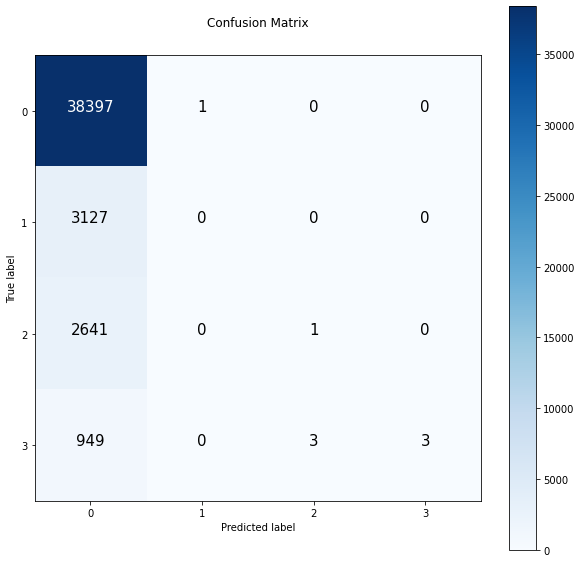

In [138]:
make_confusion_matrix(y_val,base_preds, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False)

1. The model was unable to differentiate  between classes due to the data imbalance

## Model 2 : USE encoder + Vader

In [225]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                        trainable = False,
                                        name = 'universal_sentence_encoder')

In [262]:
import tensorflow as tf
from tensorflow.keras import layers

In [292]:
X_train,X_val,y_train,y_val = train_test_split(df_sample[['text','neg','neu','pos','compound']],
                                               df_sample['label'],
                                               test_size = 0.25,
                                               stratify = df_sample['label'])

## Dealing with class imbalance

In [293]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(sampling_strategy = {0:115193,1:30000,2:20000,3:10000},random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [295]:
#1.
token_inputs = layers.Input(shape = [], dtype = tf.string , name = 'token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs,
                             outputs = token_outputs,
                             name = 'token_model')

#2.
neg_inputs = layers.Input(shape = (1,) , dtype = tf.int32, name = 'neg_input')
x = layers.Dense(32, activation = 'relu')(neg_inputs)
neg_model = tf.keras.Model(inputs = neg_inputs,
                           outputs = x)

#3.

neu_inputs = layers.Input(shape = (1,), dtype = tf.int32, name = 'neu_inputs')
y = layers.Dense(32, activation = 'relu')(neu_inputs)
neu_model = tf.keras.Model(inputs = neu_inputs,
                                  outputs = y)


#4.
pos_inputs = layers.Input(shape = (1,), dtype = tf.int32, name = 'pos_inputs')
z = layers.Dense(32, activation = 'relu')(pos_inputs)
pos_model = tf.keras.Model(inputs = pos_inputs,
                           outputs = z)

#4.
compound_inputs = layers.Input(shape = (1,), dtype = tf.int32, name = 'compound_inputs')
q = layers.Dense(32, activation = 'relu')(compound_inputs)
compound_model = tf.keras.Model(inputs = compound_inputs,
                                outputs = q)

#5. Combine token and char embedding into a hybrid embedding

combined_embeddings = layers.Concatenate(name = 'token_vader')([token_model.output,
                                                                neg_model.output,
                                                                pos_model.output,
                                                                neu_model.output,
                                                                compound_model.output])


z = layers.Dense(256,activation = 'relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)
z = layers.Dense(256,activation = 'relu')(z)
z = layers.Dropout(0.5)(z)


#7. Create output layer
output_layer = layers.Dense(4,activation = 'softmax' , name = 'output_layer')(z)

#8. Combine model

model_2 = tf.keras.Model(inputs = [token_model.input,
                                   neg_model.input,
                                   pos_model.input,
                                   neu_model.input,
                                   compound_model.input
                                   ],
                         outputs = output_layer,
                         name = 'token_vader_model')

In [296]:
model_2.summary()

Model: "token_vader_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']           
 rasLayer)                                                                                        
                                                                                                  
 neg_input (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 pos_inputs (InputLayer)        [(None, 1)]          0           []               

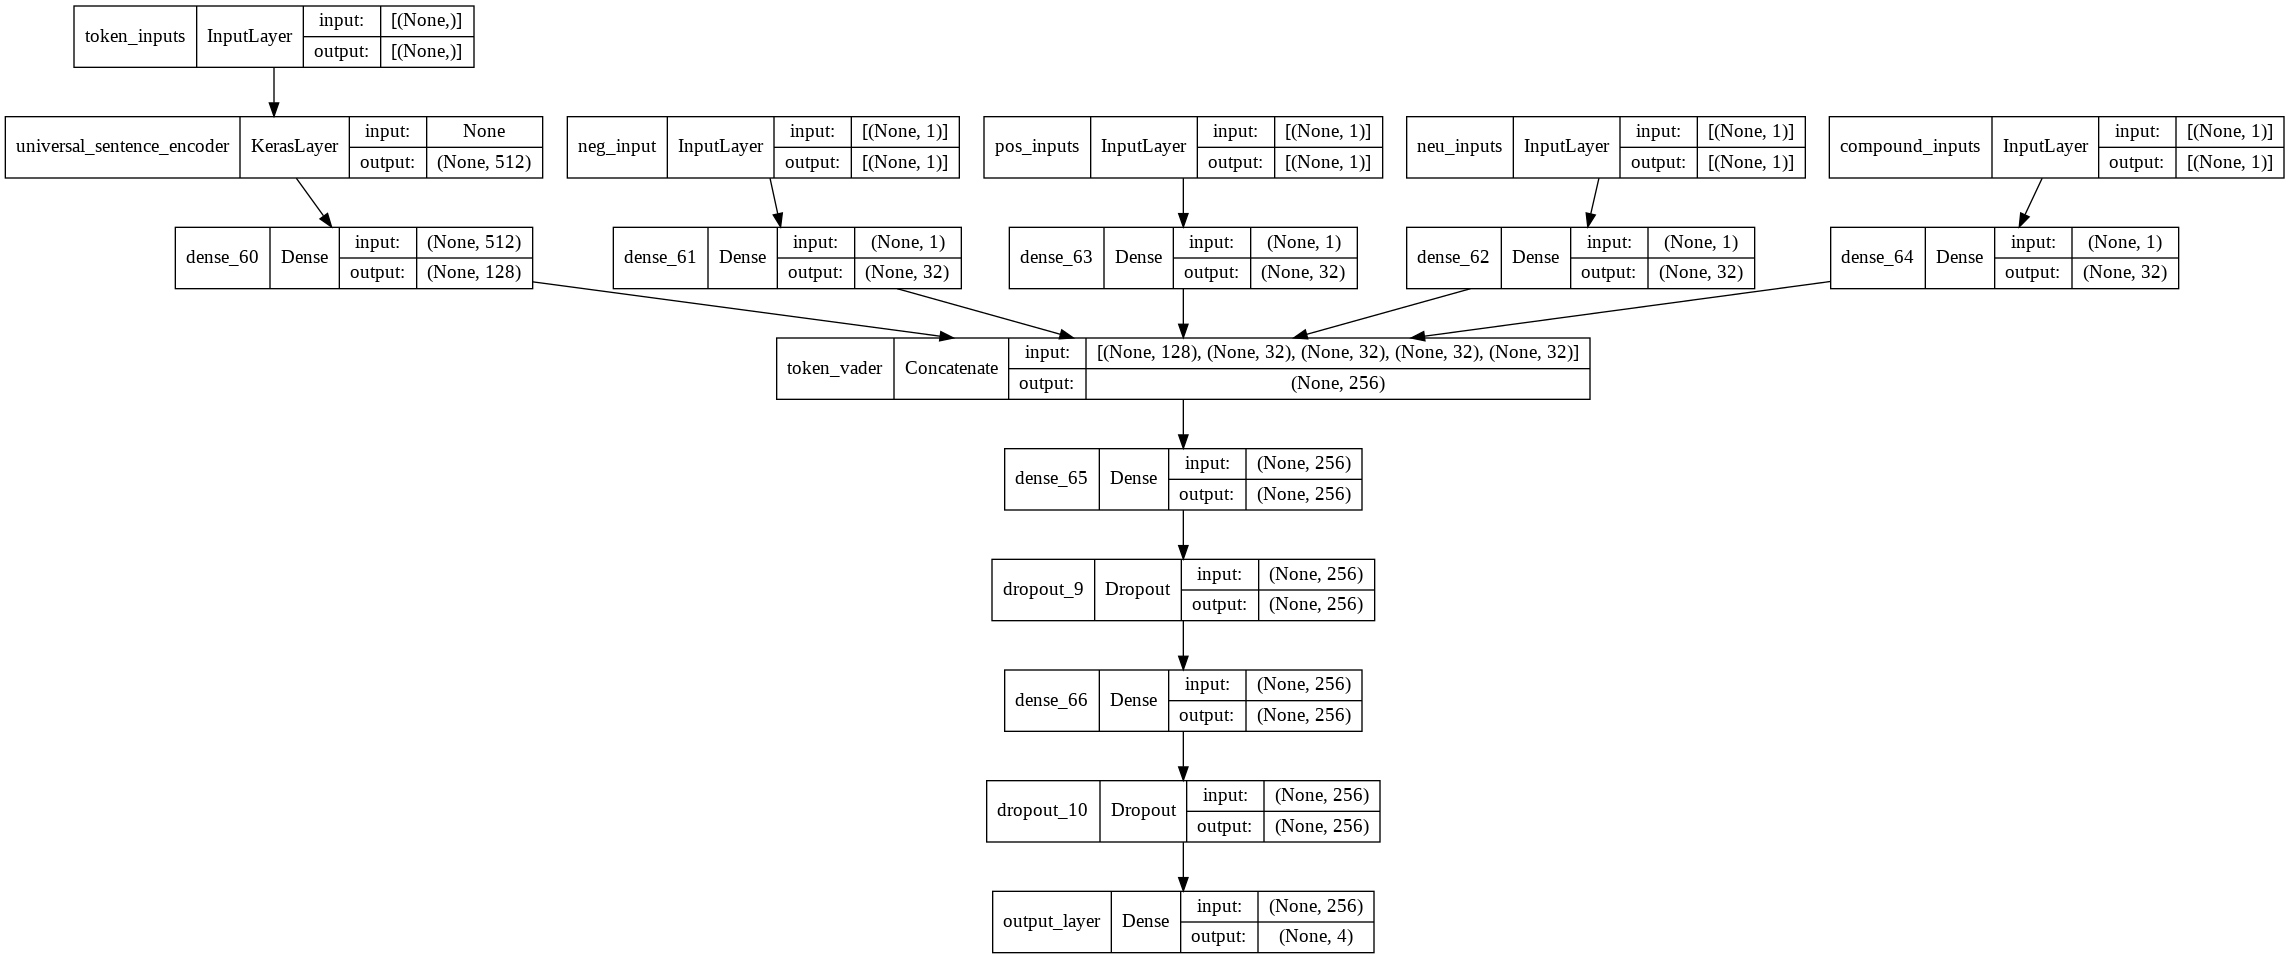

In [297]:
from tensorflow.keras.utils import plot_model
plot_model(model_2, show_shapes = True)

In [312]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [313]:
one_hot_encoder = OneHotEncoder(sparse = False)
train_labels_one_hot = one_hot_encoder.fit_transform(y_train.to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(y_val.to_numpy().reshape(-1,1))

In [314]:
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(y_train.to_numpy())
val_labels_encoded = label_encoder.transform(y_val.to_numpy())

In [315]:
train_sentences = X_train.text.tolist()
train_neg = X_train.neg.tolist()
train_pos = X_train.pos.tolist()
train_neu = X_train.neu.tolist()
train_compound = X_train.compound.tolist()

val_sentences = X_val.text.tolist()
val_neg = X_val.neg.tolist()
val_pos = X_val.pos.tolist()
val_neu = X_val.neu.tolist()
val_compound = X_val.compound.tolist()

In [316]:
train_token_vader_data = tf.data.Dataset.from_tensor_slices((train_sentences,
                                                             train_neg,
                                                             train_pos,
                                                             train_neu,
                                                             train_compound
                                                             ))

train_token_vader_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_token_vader_dataset = tf.data.Dataset.zip((train_token_vader_data,
                                                train_token_vader_labels))

train_token_vader_dataset = train_token_vader_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


val_token_vader_data = tf.data.Dataset.from_tensor_slices((val_sentences,
                                                           val_neg,
                                                           val_pos,
                                                           val_neu,
                                                           val_compound
                                                           ))

val_token_vader_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_token_vader_dataset = tf.data.Dataset.zip((val_token_vader_data,
                                              val_token_vader_labels))

val_token_vader_dataset = val_token_vader_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [330]:
earlystopping = tf.keras.callbacks.EarlyStopping(min_delta = 0.001,monitor = 'val_auc_7', verbose = 1 , patience = 2)

In [329]:
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = tf.keras.metrics.AUC(curve='PR')
                )

In [331]:
model_2_history = model_2.fit(train_token_vader_dataset,
                              steps_per_epoch = int(0.1*len(train_token_vader_dataset)),
                              epochs = 20,
                              validation_data = val_token_vader_dataset,
                              validation_steps = int(0.1*len(val_token_vader_dataset)),
                              callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath = 'model_checkpoint',
                                                                              monitor = 'val_auc_7',
                                                                              save_best_only = True,
                                                                              save_weights_only = False),
                                           earlystopping])

Epoch 1/20
546/547 [============================>.] - ETA: 0s - loss: 0.7779 - auc_7: 0.9410INFO:tensorflow:Assets written to: model_checkpoint/assets


INFO:tensorflow:Assets written to: model_checkpoint/assets


547/547 [==============================] - 42s 73ms/step - loss: 0.7781 - auc_7: 0.9409 - val_loss: 0.8357 - val_auc_7: 0.9074
Epoch 2/20
545/547 [============================>.] - ETA: 0s - loss: 0.7852 - auc_7: 0.9370INFO:tensorflow:Assets written to: model_checkpoint/assets


INFO:tensorflow:Assets written to: model_checkpoint/assets


547/547 [==============================] - 25s 46ms/step - loss: 0.7853 - auc_7: 0.9370 - val_loss: 0.8367 - val_auc_7: 0.9061
Epoch 3/20
547/547 [==============================] - 15s 27ms/step - loss: 0.8092 - auc_7: 0.9205 - val_loss: 0.8232 - val_auc_7: 0.9149
Epoch 4/20
547/547 [==============================] - 15s 27ms/step - loss: 0.8157 - auc_7: 0.9171 - val_loss: 0.8212 - val_auc_7: 0.9196
Epoch 00004: early stopping


In [334]:
model_2 = tf.keras.models.load_model('model_checkpoint/')

In [335]:
model_2.evaluate(val_token_vader_dataset)

1411/1411 [==============================] - 30s 20ms/step - loss: 0.8342 - auc_7: 0.9061


[0.8341608047485352, 0.9061274528503418]

In [336]:
preds = model_2.predict(val_token_vader_dataset)

In [337]:
predictions = np.argmax(preds,axis = 1)

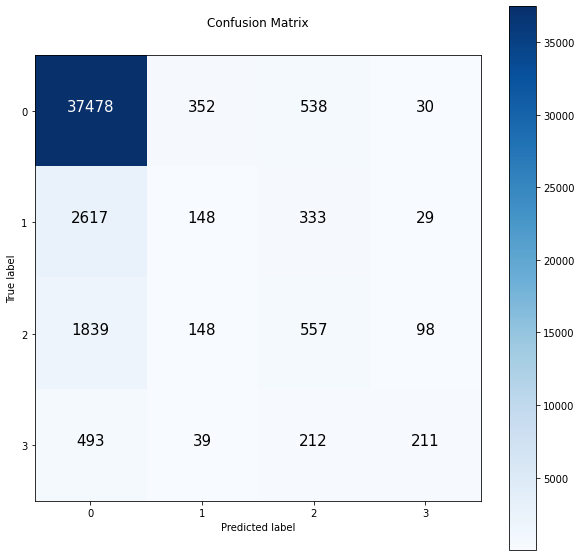

In [338]:
make_confusion_matrix(y_val,predictions, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False)